In [1]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 
#warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

import eli5
from eli5.sklearn import PermutationImportance

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('Gold1.csv')

In [3]:
df = df.sort_values(by = 'datetime')
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y/%m/%d")

df.index = df['datetime']

df = df.drop('datetime', axis = 1)

df = df['Gold_Price']


In [4]:
df.columns = ['Gold_Price']

df = pd.DataFrame(df)


In [5]:
df

,Gold_Price
datetime,
1990-01-02,399.60
1990-01-03,394.00
1990-01-04,398.60
1990-01-05,406.30
1990-01-08,403.00
...,...
2021-04-21,1792.30
2021-04-22,1781.20
2021-04-23,1777.00


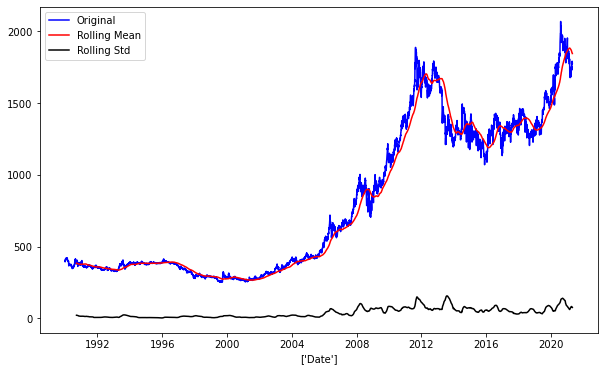

In [6]:
# 어떠한 간격을 가지고, data 출력, data의 이동 평균선, 표준편차까지 출력

def plot_rolling(data, interval):
 rolmean = data.rolling(interval).mean()
 rolstd = data.rolling(interval).std()
 #Plot rolling statistics:
 plt.figure(figsize=(10, 6))
 plt.xlabel(['Date'])
 orig = plt.plot(data, color='blue',label='Original')
 mean = plt.plot(rolmean, color='red', label='Rolling Mean')
 std = plt.plot(rolstd, color='black', label = 'Rolling Std')
 plt.legend(loc='best')
 plt.show()
plot_rolling(df, 180)

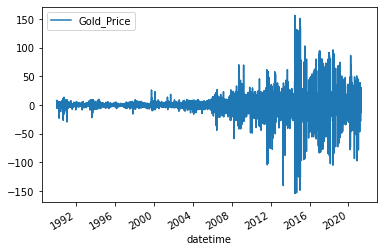

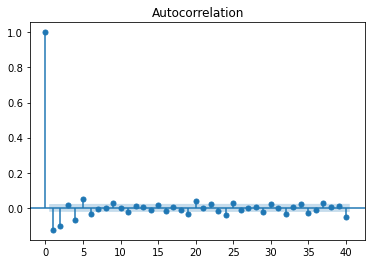

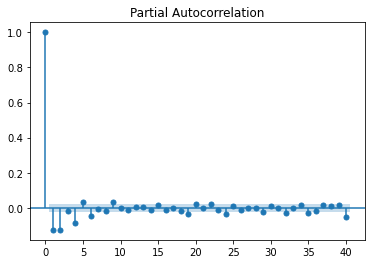

In [7]:
#ARIMA 모델 쓰려면 정상성이 있어야 하는데 원데이터는 없어서 1차 차분 데이터를 살펴봄
# 차분 데이터는 이전 값과의 차이 값을 말함

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


diff_1=df.diff(periods=1).iloc[1:]

diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.rcParams["figure.figsize"] = [25, 5]
plt.show()

In [8]:
#원데이터의 pvalue, 1차 차분 데이터의 p_value를 비교
#1차 차분 p_value가 0으로 유의미한 데이터임을 확인

from statsmodels.tsa.stattools import adfuller
y = df
y_1diff = df.diff(1).dropna()
result = adfuller(y)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: 0.280
원 데이터 p-value: 0.976
1차 차분 ADF Statistic: -16.169
1차 차분 p-value: 0.000


In [9]:
# ARIMA에서 필요한 세가지 파라미터인 p d q를 정하는 함수
# 각각 0~3 까지 넣어봐서 27가지의 경우의 수를 계산하여 AIC 값이 가장 작은 것으로 결정
# AIC는 주어진 데이터 셋에 대한 통계 모델의 상대적인 품질을 평가하는 지표다.

from statsmodels.tsa.arima_model import ARIMA
def my_auto_arima(data, order,sort = 'AIC'):
 order_list = []
 aic_list = []
 bic_lsit = []
 for p in range(order[0]):
     for d in range(order[1]):
         for q in range(order[2]):
             model = ARIMA(data, order=(p,d,q))
             try:
                 model_fit = model.fit()
                 c_order = f'p{p} d{d} q{q}'
                 aic = model_fit.aic
                 bic = model_fit.bic
                 order_list.append(c_order)
                 aic_list.append(aic)
                 bic_list.append(bic)
             except:
                 pass
 result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
 result_df.sort_values(sort, inplace=True)
 return result_df

In [10]:
my_auto_arima(df,[3,3,3])

,order,AIC
21,p2 d1 q2,64121.473037
14,p1 d1 q2,64147.301437
5,p0 d1 q2,64166.597353
18,p2 d0 q2,64166.778121
20,p2 d1 q1,64174.483760
13,p1 d1 q1,64180.674010
11,p1 d0 q2,64186.484238
19,p2 d1 q0,64188.983033
23,p2 d2 q1,64192.378596
17,p2 d0 q1,64200.906568


                             ARIMA Model Results                              
Dep. Variable:           D.Gold_Price   No. Observations:                 7968
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -32054.737
Method:                       css-mle   S.D. of innovations             13.518
Date:                Wed, 28 Apr 2021   AIC                          64121.473
Time:                        18:27:02   BIC                          64163.372
Sample:                             1   HQIC                         64135.817
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1729      0.108      1.606      0.108      -0.038       0.384
ar.L1.D.Gold_Price    -0.4208      0.050     -8.416      0.000      -0.519      -0.323
ar.L2.D.Gold_Price  

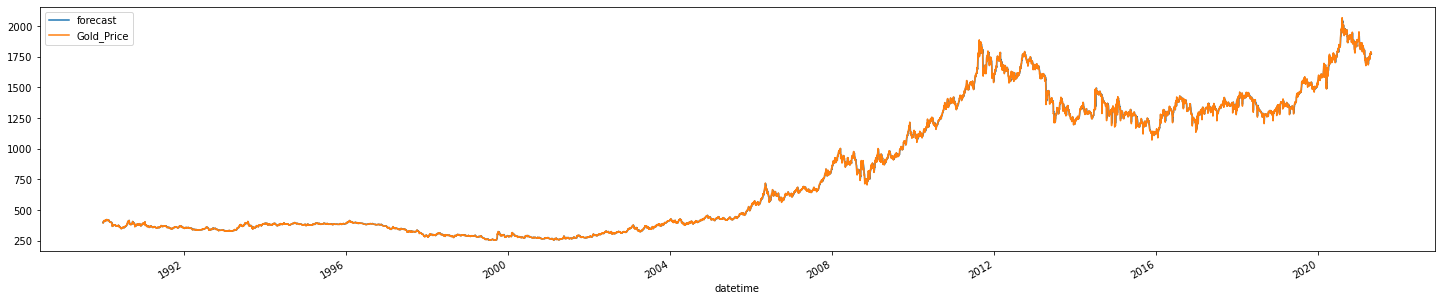

In [11]:
# p d q를 2 1 2 로 설정하고 모델 생성

model = ARIMA(df, (2,1,2))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_predict()
plt.show()

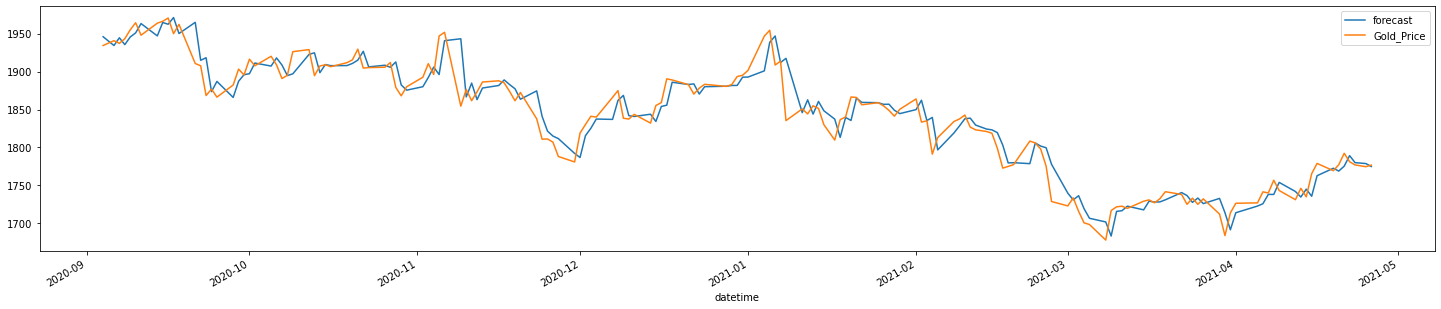

In [12]:
import datetime
model_fit.plot_predict(start=df.index[7800])
plt.rcParams["figure.figsize"] = [20, 10]
plt.show()

In [13]:
df

,Gold_Price
datetime,
1990-01-02,399.60
1990-01-03,394.00
1990-01-04,398.60
1990-01-05,406.30
1990-01-08,403.00
...,...
2021-04-21,1792.30
2021-04-22,1781.20
2021-04-23,1777.00


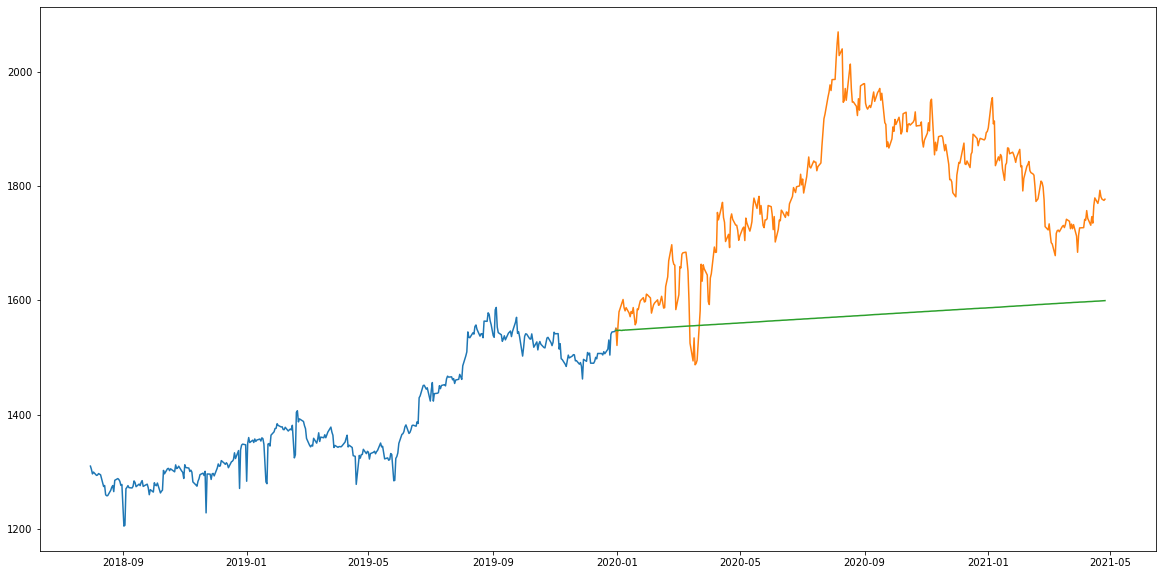

In [16]:
#1990 년부터 2019.12.31 까지 학습 시키고
# 2020년부터 현재까지의 데이터를 예측 시키는 모델 만듬

train, test = df.loc[:datetime.datetime(2019,12,31),:], df.loc[datetime.datetime(2019,12,31):,:]
model = ARIMA(train,(2,1,2))
model_fit = model.fit()
full_forecast = model_fit.forecast(steps=test.shape[0])
forecast = pd.DataFrame(full_forecast[0], index=test.index, columns=test.columns)
plt.plot(train.loc[datetime.datetime(2018,7,31):,:])
plt.plot(test)
plt.plot(forecast)

In [19]:
from sklearn.metrics import r2_score
print(r2_score(test,forecast))

-2.883911067388649


In [20]:
print('검증 RMSE: ', np.sqrt(mean_squared_error(test, forecast)))

검증 RMSE:  241.93110370036484


In [21]:
from sklearn.metrics import r2_score
print(r2_score(test,forecast))

-2.883911067388649


# ARIMA 결론

ARIMA 예측 모델 그래프에서 

파란색 선은 학습 데이터
주황색은 테스트 데이터
초록색은 이제 예측한 데이터를 나타낸 것이다.

ARIMA로는 데이터 예측이 잘 맞지 않는 다는 것을 알았다.


RMSE = 표준편차와 동일하다. 특정 수치에 대한 예측의 정확도를 표현할 때, Accuracy로 판단하기에는 정확도를 올바르게 표기할 수 없어, RMSE 수치로 정확도 판단을 하곤 한다. 일반적으로 해당 수치가 낮을수록 정확도가 높다고 판단한다.